In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os.path
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from ultralytics import YOLO
from PIL import Image
import os
from os import listdir
import string
import numpy as np
from pathlib import Path
import pdb

2023-07-26 14:37:14.518434: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 14:37:14.523926: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 14:37:14.574243: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 14:37:14.574968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 14:37:15.500033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
confThreshold = 0.5
nmsThreshold = 0.4
netsize = 416

In [3]:
classesFile = "/content/drive/MyDrive/Slike/tablice-v1/yolo_utils/classes.names";

In [4]:
def input():
  input_path = '/content/drive/MyDrive/Slike/tablice-v1/sabac.jpg'
  op = cv2.imread(input_path)
  image = cv2.cvtColor(op, cv2.COLOR_RGB2BGR)
  plt.imshow(image)
  plt.show()
  return image

In [5]:
def predict(img):
    detector = YOLO('/content/drive/MyDrive/Slike/tablice-v1/best.pt')
    plates = detector(img)[0]
    found = []

    for pl in plates.boxes.data.tolist():
        x1, y1, x2, y2, _, class_id = pl
        if int(class_id)==0:
            found.append([int(x1), int(y1), int(x2), int(y2)])
    return found

def detect_plate(img):

  imgt = img
  imgt1 = np.copy(imgt)

  found = predict(imgt)


  for tabl in found:
      x1 = tabl[0]
      y1 = tabl[1]
      x2 = tabl[2]
      y2 = tabl[3]
      imgt = cv2.rectangle(imgt, (x1, y1), (x2, y2), (255,0,0), 10)
      copy = np.copy(img)
      cropped_image = copy[y1:y2, x1:x2]
      #imgt = cv2.cvtColor(imgt, cv2.COLOR_BGR2RGB)
      plt.imshow(imgt)
      plt.show()
      plt.imshow(cropped_image)
      plt.show()

  return cropped_image



In [6]:
def projective_transform(img, x1, y1, x2, y2, x3, y3, x4, y4):
    plate_corners = np.array([[x1, y1], [x2, y2], [x4, y4], [x3, y3]], dtype=np.float32)
    plate_width = int(max(np.linalg.norm(plate_corners[0] - plate_corners[1]), np.linalg.norm(plate_corners[2] - plate_corners[3])))
    plate_height = int(max(np.linalg.norm(plate_corners[0] - plate_corners[3]), np.linalg.norm(plate_corners[1] - plate_corners[2])))
    target_corners = np.array([[0, 0], [plate_width - 1, 0], [plate_width - 1, plate_height - 1], [0, plate_height - 1]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(plate_corners, target_corners)
    plate_transformed = cv2.warpPerspective(img, M, (plate_width, plate_height))

    return plate_transformed

In [7]:
def getpoints(image, u):
    tl = None
    tr = None
    bl = None
    br = None

    width, height = image.shape

    for i in range(0, width, 1):
        for j in range(0, min(i + 1, height), 1):
            if tl is None:
                x = i - j
                y = j

                if image[y][x] >u:
                    tl = (x, y)

            if tr is None:
                x = j - i + height - 1
                y = j

                if image[y][x] >u:
                    tr = (x, y)

            if bl is None:
                x = i - j
                y = width - j - 1

                if image[y][x] >u:
                    bl = (x, y)

            if br is None:
                x = j - i + height - 1
                y = width - j - 1

                if image[y][x] >u:
                    br = (x, y)

            if tl is not None and tr is not None and bl is not None and br is not None:
                break

    return [tl, tr, bl, br]

In [8]:
def rotate_plate(cropped):
  image = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
  image.shape
  edges = cv2.Canny(image, 255, 255 / 3)

  contours, _ = cv2.findContours(edges,
      cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  contours = sorted(contours, key=cv2.contourArea, reverse=True)
  contour = contours[0]

  width, height = image.shape

  contoursimg = np.zeros([width, height, 1], dtype="uint8")

  for i, [[x, y]] in enumerate(contour):
      contoursimg[y,x]=255

  filledimg = cv2.fillPoly(contoursimg.copy(), pts=[contour], color=(255,255,255))
  kernel = np.ones([10, 10])
  processedimg = cv2.erode(filledimg.copy(), kernel)
  processedimg = cv2.dilate(processedimg, kernel)

  points = getpoints(processedimg, 127)

  finalimg = cv2.cvtColor(cropped.copy(), cv2.COLOR_GRAY2RGB)
  for [x, y] in points:
      cv2.circle(finalimg, (x, y), 10, (255, 255, 0), -1)

  plt.imshow(finalimg)
  plt.title("finalimg")
  plt.show()
  cropped = projective_transform(cropped, points[0][0], points[0][1], points[1][0], points[1][1], points[2][0], points[2][1], points[3][0], points[3][1])
  plt.imshow(cropped)
  plt.show()
  return cropped

In [9]:
def segment_characters(image) :
    img_lp = cv2.resize(image, (333, 75))
    img2 = np.copy(img_lp)
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 190, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    dimensions = [15,35,47,62]

    char_list = find_contours(dimensions, img_binary_lp, img2)
    return char_list

In [10]:
def find_contours(dimensions, img, img2) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = img2

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX)
            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            char = cv2.subtract(255, char)

            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)

    plt.show()

    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

In [11]:
def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
      new_img[:,:,i] = img
      return new_img

def show_results(char, cropped, loaded_model):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char):
        ch = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        ch = ch/255
        ch1 = fix_dimension(ch)
        img1 = ch1.reshape(1,28,28,3)

        l = loaded_model.predict(img1).tolist()[0]
        print(l)
        try:
            y_ = np.argmax(l)
        except:
            return ""
        character = dic[y_]
        output.append(character)

    plate_number = ''.join(output)
    return plate_number


def read(char, cropped):
  loaded_model = Sequential()
  loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
  loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
  loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
  loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
  loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
  loaded_model.add(Dropout(0.4))
  loaded_model.add(Flatten())
  loaded_model.add(Dense(128, activation='relu'))
  loaded_model.add(Dense(36, activation='softmax'))
  loaded_model.load_weights('/content/drive/MyDrive/Slike/tablice-v1/checkpoints/my_checkpoint')

  reg = show_results(char, cropped, loaded_model)
  return reg



In [12]:
img = input()

[ WARN:0@4.053] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/content/drive/MyDrive/Slike/tablice-v1/sabac.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



0: 384x640 1 License_Plate, 605.7ms
Speed: 3.7ms preprocess, 605.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


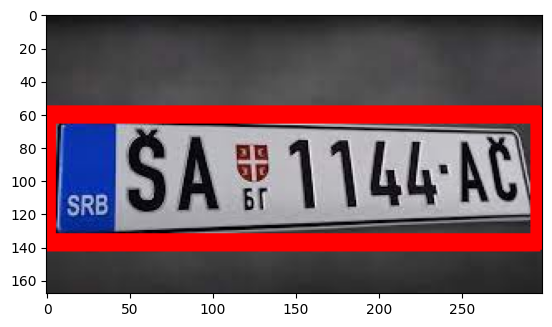

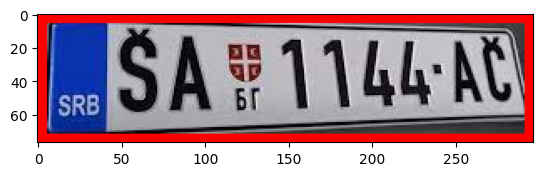

In [ ]:
cropped = detect_plate(img)

In [ ]:
rotated = rotate_plate(cropped)

TypeError: ignored

In [ ]:
char = segment_characters(rotated)

In [ ]:
reg = read(char, rotated)

In [ ]:
print("Registration:", reg)